<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: Calwebb_Image3, Resample step with MIRI LRS slit

<span style="color:red"> **Instruments Affected**</span>: MIRI

Tested on MIRI Simulated data

### Table of Contents
<div style="text-align: left"> 

<br>  [Introduction](#intro_ID) <br> [Run JWST Pipelines](#pipeline_ID) <br> [Imports](#imports_ID) <br> [Create an association table for your cal files and run them through calwebb_image3](#runpipeline_ID) <br> [Find Stars in Image and Determine their Coordinates](#runscript_ID) <br> [Compare RA and Dec to expected Values](#residual_ID) <br> [About This Notebook](#about_ID) <br>


</div>

<a id="intro_ID"></a>
# Introduction


This test is designed to test the resample step in the calwebb_spec3 pipeline. This step takes the dither positions in an association table and combines them into 1 output product. Resample applies the distortion correction using the drizzling algorithm (as defined in the DrizzlePac handbook) and combines the listed files. For more information on the pipeline step visit the links below. 

Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/resample/main.html

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/resample

The data for this test were created with the MIRI Data Simulator for LRS Slit, and the documentation for that code can be found here: http://miri.ster.kuleuven.be/bin/view/Public/MIRISim_Public


### Calibration WG Requested Algorithm: 

A short description and link to the page: https://outerspace.stsci.edu/display/JWSTCC/Vanilla+Resample+Slit+Spectra


### Defining Terms
Definition of terms or acronymns.

JWST: James Webb Space Telescope

MIRI: Mid-Infrared Instrument

MIRISim: MIRI Data Simulator



[Top of Page](#title_ID)

In [1]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
data_dir = TemporaryDirectory()
os.chdir(data_dir.name)
print(data_dir)

<TemporaryDirectory '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpudhc0j9q'>


In [2]:
import os
if 'CRDS_CACHE_TYPE' in os.environ:
    if os.environ['CRDS_CACHE_TYPE'] == 'local':
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif os.path.isdir(os.environ['CRDS_CACHE_TYPE']):
        os.environ['CRDS_PATH'] = os.environ['CRDS_CACHE_TYPE']
print('CRDS cache location: {}'.format(os.environ['CRDS_PATH']))

CRDS cache location: /grp/crds/cache



<a id="imports_ID"></a>
# Imports
The following packages will need to be imported for the scripts to work.


* astropy.io for opening files
* ci_watson.artifactory_helpers to read in data from artifactory
* jwst.datamodels for opening files as a JWST Datamodel
* jwst.pipeline to run the pipeline step/module
* jwst.associations to create association table
* numpy for calculations
* matplotlib.pyplot.plt to generate plot
* os for path information  
* photutils for star finding and aperture photometry
* regtest to retrieve data from artifactory needed to run notebook


[Top of Page](#title_ID)

In [3]:
from astropy.io import ascii, fits
from astropy.modeling import models, fitting
from ci_watson.artifactory_helpers import get_bigdata
import glob

import jwst
from jwst.pipeline import Detector1Pipeline, Spec2Pipeline, Spec3Pipeline
from jwst import associations, datamodels
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase
from jwst.associations.asn_from_list import asn_from_list
from jwst.regtest.regtestdata import RegtestData

import matplotlib.pyplot as plt
import numpy as np
import os


## Read in uncal data from artifactory 


In [4]:
print("Downloading input files")
 
#This readnoise file is needed for use with simulated data which has higher readnoise than actual data.
readnoise = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'jump',                     
                     'jump_miri_test', 
                     'jwst_mirisim_readnoise.fits')

Slitfile1 = get_bigdata('jwst_validation_notebooks',
                                     'validation_data',
                                     'calwebb_spec2',
                                    'spec2_miri_test',
                                    'miri_lrs_slit_pt_nod1_v2.3.fits')
 
Slitfile2 = get_bigdata('jwst_validation_notebooks',
                                     'validation_data',
                                     'calwebb_spec2',
                                    'spec2_miri_test',
                                    'miri_lrs_slit_pt_nod2_v2.3.fits')

files = [Slitfile1, Slitfile2]

print("Finished Downloads")


Finished Downloads


<a id="pipeline_ID"></a>
# Run JWST Pipeline

First we run the data through the Detector1() pipeline to convert the raw counts into slopes. This should use the calwebb_detector1.cfg file. The output of this stage will then be run through the Spec2Pipeline. Extract_1d is the final step of this pipeline stage, so we will just run through the whole pipeline.

[Top of Page](#title_ID)

### Detector 1 Pipeline

In [5]:
# Run the calwebb_detector1 pipeline

# set up pipeline parameters 
rej_thresh=10.0  # rejection threshold for jump step

det1 = []

# Run pipeline on both files
for ff in files:
    d1 = Detector1Pipeline.call(ff, steps={'jump':{'rejection_threshold':rej_thresh, 'override_readnoise': readnoise},
                                           'ramp_fit': {'override_readnoise': readnoise}, 'refpix': {'skip': True}},
                                save_results=True)
    det1.append(d1)

print(det1)

2022-12-04 04:54:21,342 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2022-12-04 04:54:21,367 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-12-04 04:54:21,369 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-12-04 04:54:21,370 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-12-04 04:54:21,371 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-12-04 04:54:21,372 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-12-04 04:54:21,374 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-12-04 04:54:21,375 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-12-04 04:54:21,376 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-12-04 04:54:21,377 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-12-04 04:54:21,378 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-12-04 04:54:21,379 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-12-04 04:54:21,380 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-12-04 04:54:21,381 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-12-04 04:54:21,382 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-12-04 04:54:21,384 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-12-04 04:54:21,385 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-12-04 04:54:21,386 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-12-04 04:54:21,530 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpudhc0j9q/miri_lrs_slit_pt_nod1_v2.3.fits',).


2022-12-04 04:54:21,540 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-12-04 04:54:21,735 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'miri_lrs_slit_pt_nod1_v2.3.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-12-04 04:54:21,743 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2022-12-04 04:54:21,745 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2022-12-04 04:54:21,747 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2022-12-04 04:54:21,749 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits'.


2022-12-04 04:54:21,751 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-12-04 04:54:21,751 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpudhc0j9q/jwst_mirisim_readnoise.fits'.


2022-12-04 04:54:21,752 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2022-12-04 04:54:21,753 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits'.


2022-12-04 04:54:21,755 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2022-12-04 04:54:21,756 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-12-04 04:54:21,756 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-12-04 04:54:21,757 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-12-04 04:54:21,757 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-12-04 04:54:22,142 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-12-04 04:54:22,144 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpudhc0j9q'}


2022-12-04 04:54:22,271 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-12-04 04:54:22,272 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-12-04 04:54:22,275 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-12-04 04:54:22,453 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-12-04 04:54:22,455 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpudhc0j9q'}


2022-12-04 04:54:22,478 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits


2022-12-04 04:54:22,805 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-12-04 04:54:22,982 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-12-04 04:54:22,983 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpudhc0j9q', 'n_pix_grow_sat': 1}


2022-12-04 04:54:23,007 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2022-12-04 04:54:24,131 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2022-12-04 04:54:24,145 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-12-04 04:54:24,159 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-12-04 04:54:24,349 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-12-04 04:54:24,350 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpudhc0j9q'}


2022-12-04 04:54:24,351 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-12-04 04:54:24,354 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-12-04 04:54:24,533 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-12-04 04:54:24,535 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpudhc0j9q'}


2022-12-04 04:54:24,668 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-12-04 04:54:24,852 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-12-04 04:54:24,854 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpudhc0j9q'}


2022-12-04 04:54:24,980 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-12-04 04:54:25,162 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-12-04 04:54:25,165 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpudhc0j9q'}


2022-12-04 04:54:25,190 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2022-12-04 04:54:27,017 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-12-04 04:54:27,196 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-12-04 04:54:27,198 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpudhc0j9q'}


2022-12-04 04:54:27,222 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2022-12-04 04:54:28,118 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-12-04 04:54:28,281 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-12-04 04:54:28,283 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpudhc0j9q', 'type': 'baseline'}


2022-12-04 04:54:28,306 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits


2022-12-04 04:54:28,479 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-12-04 04:54:28,680 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-12-04 04:54:28,682 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpudhc0j9q', 'dark_output': None}


2022-12-04 04:54:28,706 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2022-12-04 04:54:50,749 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=10, nframes=1, groupgap=0


2022-12-04 04:54:50,750 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2022-12-04 04:54:51,506 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-12-04 04:54:51,677 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-12-04 04:54:51,679 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpudhc0j9q', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-12-04 04:54:51,680 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-12-04 04:54:51,683 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-12-04 04:54:51,846 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-12-04 04:54:51,849 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpudhc0j9q', 'rejection_threshold': 10.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0, 'min_sat_area': 1.0, 'min_jump_area': 5.0, 'expand_factor': 2.0, 'use_ellipses': False, 'sat_required_snowball': True, 'expand_large_events': False}


2022-12-04 04:54:51,860 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 10 sigma


2022-12-04 04:54:51,878 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-12-04 04:54:51,960 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpudhc0j9q/jwst_mirisim_readnoise.fits


2022-12-04 04:54:52,164 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-12-04 04:54:52,210 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-12-04 04:54:53,114 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 833 pixels with at least one CR from five or more groups.


2022-12-04 04:54:53,312 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-12-04 04:54:54,272 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 471 pixels with at least one CR from five or more groups.


2022-12-04 04:54:54,405 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 2.23947 sec


2022-12-04 04:54:54,465 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 2.605027


2022-12-04 04:54:54,471 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-12-04 04:54:54,631 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-12-04 04:54:54,633 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpudhc0j9q', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-12-04 04:54:54,656 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpudhc0j9q/jwst_mirisim_readnoise.fits


2022-12-04 04:54:54,657 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-12-04 04:54:54,708 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-12-04 04:54:54,709 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-12-04 04:54:54,798 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-12-04 04:54:54,799 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-12-04 04:55:03,791 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2022-12-04 04:55:03,795 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 2


2022-12-04 04:55:03,904 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-12-04 04:55:04,073 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-12-04 04:55:04,074 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpudhc0j9q'}


2022-12-04 04:55:04,117 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-12-04 04:55:04,118 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-12-04 04:55:04,123 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-12-04 04:55:04,230 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-12-04 04:55:04,231 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpudhc0j9q'}


2022-12-04 04:55:04,274 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-12-04 04:55:04,275 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-12-04 04:55:04,279 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-12-04 04:55:04,382 - stpipe.Detector1Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod1_v2.3_rateints.fits


2022-12-04 04:55:04,383 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-12-04 04:55:04,383 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-04 04:55:04,453 - stpipe.Detector1Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod1_v2.3_rate.fits


2022-12-04 04:55:04,454 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-12-04 04:55:04,667 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2022-12-04 04:55:04,684 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-12-04 04:55:04,685 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-12-04 04:55:04,687 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-12-04 04:55:04,688 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-12-04 04:55:04,689 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-12-04 04:55:04,690 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-12-04 04:55:04,691 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-12-04 04:55:04,692 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-12-04 04:55:04,693 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-12-04 04:55:04,694 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-12-04 04:55:04,696 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-12-04 04:55:04,697 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-12-04 04:55:04,698 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-12-04 04:55:04,699 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-12-04 04:55:04,700 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-12-04 04:55:04,701 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-12-04 04:55:04,702 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-12-04 04:55:04,811 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpudhc0j9q/miri_lrs_slit_pt_nod2_v2.3.fits',).


2022-12-04 04:55:04,820 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-12-04 04:55:05,015 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'miri_lrs_slit_pt_nod2_v2.3.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-12-04 04:55:05,023 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2022-12-04 04:55:05,025 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2022-12-04 04:55:05,026 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2022-12-04 04:55:05,028 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits'.


2022-12-04 04:55:05,031 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-12-04 04:55:05,031 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpudhc0j9q/jwst_mirisim_readnoise.fits'.


2022-12-04 04:55:05,032 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2022-12-04 04:55:05,034 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits'.


2022-12-04 04:55:05,035 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2022-12-04 04:55:05,037 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-12-04 04:55:05,037 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-12-04 04:55:05,038 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-12-04 04:55:05,038 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-12-04 04:55:05,349 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-12-04 04:55:05,351 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpudhc0j9q'}


2022-12-04 04:55:05,466 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-12-04 04:55:05,467 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-12-04 04:55:05,469 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-12-04 04:55:05,579 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-12-04 04:55:05,581 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpudhc0j9q'}


2022-12-04 04:55:05,604 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits


2022-12-04 04:55:05,875 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-12-04 04:55:05,980 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-12-04 04:55:05,982 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpudhc0j9q', 'n_pix_grow_sat': 1}


2022-12-04 04:55:06,004 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2022-12-04 04:55:06,994 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2022-12-04 04:55:07,006 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-12-04 04:55:07,014 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-12-04 04:55:07,117 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-12-04 04:55:07,118 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpudhc0j9q'}


2022-12-04 04:55:07,118 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-12-04 04:55:07,121 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-12-04 04:55:07,220 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-12-04 04:55:07,221 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpudhc0j9q'}


2022-12-04 04:55:07,343 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-12-04 04:55:07,469 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-12-04 04:55:07,471 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpudhc0j9q'}


2022-12-04 04:55:07,592 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-12-04 04:55:07,698 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-12-04 04:55:07,699 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpudhc0j9q'}


2022-12-04 04:55:07,722 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2022-12-04 04:55:08,071 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-12-04 04:55:08,176 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-12-04 04:55:08,178 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpudhc0j9q'}


2022-12-04 04:55:08,200 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2022-12-04 04:55:08,627 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-12-04 04:55:08,734 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-12-04 04:55:08,735 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpudhc0j9q', 'type': 'baseline'}


2022-12-04 04:55:08,758 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits


2022-12-04 04:55:08,916 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-12-04 04:55:09,027 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-12-04 04:55:09,028 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpudhc0j9q', 'dark_output': None}


2022-12-04 04:55:09,053 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2022-12-04 04:55:10,492 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=10, nframes=1, groupgap=0


2022-12-04 04:55:10,493 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2022-12-04 04:55:11,257 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-12-04 04:55:11,381 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-12-04 04:55:11,383 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpudhc0j9q', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-12-04 04:55:11,383 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-12-04 04:55:11,386 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-12-04 04:55:11,495 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-12-04 04:55:11,497 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpudhc0j9q', 'rejection_threshold': 10.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0, 'min_sat_area': 1.0, 'min_jump_area': 5.0, 'expand_factor': 2.0, 'use_ellipses': False, 'sat_required_snowball': True, 'expand_large_events': False}


2022-12-04 04:55:11,508 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 10 sigma


2022-12-04 04:55:11,522 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-12-04 04:55:11,547 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpudhc0j9q/jwst_mirisim_readnoise.fits


2022-12-04 04:55:11,750 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-12-04 04:55:11,791 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-12-04 04:55:12,693 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 881 pixels with at least one CR from five or more groups.


2022-12-04 04:55:12,902 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-12-04 04:55:13,861 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 528 pixels with at least one CR from five or more groups.


2022-12-04 04:55:14,000 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 2.24964 sec


2022-12-04 04:55:14,061 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 2.553062


2022-12-04 04:55:14,067 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-12-04 04:55:14,180 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-12-04 04:55:14,181 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpudhc0j9q', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-12-04 04:55:14,205 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpudhc0j9q/jwst_mirisim_readnoise.fits


2022-12-04 04:55:14,205 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-12-04 04:55:14,258 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-12-04 04:55:14,259 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-12-04 04:55:14,349 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-12-04 04:55:14,350 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-12-04 04:55:23,215 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2022-12-04 04:55:23,217 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 2


2022-12-04 04:55:23,348 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-12-04 04:55:23,489 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-12-04 04:55:23,491 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpudhc0j9q'}


2022-12-04 04:55:23,530 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-12-04 04:55:23,531 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-12-04 04:55:23,536 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-12-04 04:55:23,646 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-12-04 04:55:23,648 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpudhc0j9q'}


2022-12-04 04:55:23,691 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-12-04 04:55:23,692 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-12-04 04:55:23,697 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-12-04 04:55:23,797 - stpipe.Detector1Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod2_v2.3_rateints.fits


2022-12-04 04:55:23,798 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-12-04 04:55:23,798 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-04 04:55:23,870 - stpipe.Detector1Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod2_v2.3_rate.fits


2022-12-04 04:55:23,870 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


[<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>, <ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>]


In [6]:
print(jwst.__version__)

1.8.2


### Spec2 Pipeline

For the Spec2Pipeline we have to produce an association telling the pipeline that the nods should be used as each other's background. Then we call the pipeline with default parameters & settings. 

In [7]:
asn_files = [det1[0].meta.filename, det1[1].meta.filename]
asn = asn_from_list(asn_files, rule=DMSLevel2bBase, meta={'program':'test', 'target':'bd60', 'asn_pool':'test'})

# now add the opposite nod as background exposure:
asn['products'][0]['members'].append({'expname': 'miri_lrs_slit_pt_nod2_v2.3_rate.fits', 'exptype':'background'})
asn['products'][1]['members'].append({'expname': 'miri_lrs_slit_pt_nod1_v2.3_rate.fits', 'exptype':'background'})

# write this out to a json file
with open('lrs-slit-test_spec2asn.json', 'w') as fp:
    fp.write(asn.dump()[1])

In [8]:
sp2 = Spec2Pipeline.call('lrs-slit-test_spec2asn.json', save_results=True)

2022-12-04 04:55:23,969 - CRDS - ERROR -  Error determining best reference for 'pars-residualfringestep'  =   Unknown reference type 'pars-residualfringestep'


2022-12-04 04:55:23,974 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-spec2pipeline_0003.asdf


2022-12-04 04:55:24,017 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2022-12-04 04:55:24,018 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-12-04 04:55:24,019 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-12-04 04:55:24,021 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2022-12-04 04:55:24,022 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2022-12-04 04:55:24,023 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2022-12-04 04:55:24,026 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2022-12-04 04:55:24,027 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2022-12-04 04:55:24,028 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2022-12-04 04:55:24,030 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2022-12-04 04:55:24,031 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2022-12-04 04:55:24,031 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2022-12-04 04:55:24,033 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-12-04 04:55:24,034 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2022-12-04 04:55:24,036 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2022-12-04 04:55:24,037 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2022-12-04 04:55:24,039 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2022-12-04 04:55:24,040 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2022-12-04 04:55:24,041 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2022-12-04 04:55:24,043 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2022-12-04 04:55:24,044 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2022-12-04 04:55:24,047 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2022-12-04 04:55:24,049 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2022-12-04 04:55:24,051 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2022-12-04 04:55:24,166 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('lrs-slit-test_spec2asn.json',).


2022-12-04 04:55:24,180 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix'

2022-12-04 04:55:24,238 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'miri_lrs_slit_pt_nod1_v2.3_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap', 'wfssbkg']


2022-12-04 04:55:24,247 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/grp/crds/cache/references/jwst/jwst_miri_apcorr_0007.fits'.


2022-12-04 04:55:24,249 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2022-12-04 04:55:24,249 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2022-12-04 04:55:24,250 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-12-04 04:55:24,250 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-12-04 04:55:24,251 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is 'N/A'.


2022-12-04 04:55:24,251 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-12-04 04:55:24,251 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-12-04 04:55:24,252 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2022-12-04 04:55:24,253 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-12-04 04:55:24,254 - stpipe.Spec2Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/grp/crds/cache/references/jwst/jwst_miri_extract1d_0004.json'.


2022-12-04 04:55:24,256 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-12-04 04:55:24,256 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2022-12-04 04:55:24,256 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0736.fits'.


2022-12-04 04:55:24,258 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-12-04 04:55:24,258 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-12-04 04:55:24,259 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2022-12-04 04:55:24,259 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-12-04 04:55:24,259 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-12-04 04:55:24,260 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-12-04 04:55:24,260 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is 'N/A'.


2022-12-04 04:55:24,260 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-12-04 04:55:24,260 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2022-12-04 04:55:24,261 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-12-04 04:55:24,261 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is '/grp/crds/cache/references/jwst/jwst_miri_pathloss_0001.fits'.


2022-12-04 04:55:24,262 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0072.fits'.


2022-12-04 04:55:24,264 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2022-12-04 04:55:24,264 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-12-04 04:55:24,264 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2022-12-04 04:55:24,265 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2022-12-04 04:55:24,265 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECTRACE reference file is 'N/A'.


2022-12-04 04:55:24,265 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0003.fits'.


2022-12-04 04:55:24,267 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2022-12-04 04:55:24,267 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2022-12-04 04:55:24,267 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVEMAP reference file is 'N/A'.


2022-12-04 04:55:24,268 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-12-04 04:55:24,268 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2022-12-04 04:55:24,276 - stpipe.Spec2Pipeline - INFO - Processing product miri_lrs_slit_pt_nod1_v2.3


2022-12-04 04:55:24,276 - stpipe.Spec2Pipeline - INFO - Working on input miri_lrs_slit_pt_nod1_v2.3_rate.fits ...


2022-12-04 04:55:24,422 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>,).


2022-12-04 04:55:24,424 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.1, 'sip_degree': None, 'sip_max_inv_pix_error': 0.1, 'sip_inv_degree': None, 'sip_npoints': 12, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-12-04 04:55:24,718 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_lrs-fixedslit pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0003.fits', 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-12-04 04:55:24,824 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.000379612 -0.000035778 0.000379612 0.000080412 359.999082432 0.000080412 359.999082432 -0.000035778


2022-12-04 04:55:24,825 - stpipe.Spec2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.000379612 -0.000035778 0.000379612 0.000080412 359.999082432 0.000080412 359.999082432 -0.000035778


2022-12-04 04:55:24,825 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-12-04 04:55:24,840 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-12-04 04:55:24,957 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>, ['miri_lrs_slit_pt_nod2_v2.3_rate.fits']).


2022-12-04 04:55:24,959 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'bsub', 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}


2022-12-04 04:55:25,020 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Accumulate bkg from miri_lrs_slit_pt_nod2_v2.3_rate.fits


2022-12-04 04:55:25,316 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2022-12-04 04:55:25,445 - stpipe.Spec2Pipeline - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:419: ResourceWarning: unclosed file <_io.BufferedReader name='miri_lrs_slit_pt_nod2_v2.3_rate.fits'>
  gc.collect()



2022-12-04 04:55:25,450 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>, []).


2022-12-04 04:55:25,451 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-04 04:55:25,452 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2022-12-04 04:55:25,455 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2022-12-04 04:55:25,568 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>,).


2022-12-04 04:55:25,570 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-04 04:55:25,570 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2022-12-04 04:55:25,573 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2022-12-04 04:55:25,690 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>,).


2022-12-04 04:55:25,691 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'source_type': None}


2022-12-04 04:55:25,700 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_LRS-FIXEDSLIT


2022-12-04 04:55:25,700 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2022-12-04 04:55:25,701 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2022-12-04 04:55:25,701 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = POINT


2022-12-04 04:55:25,705 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2022-12-04 04:55:25,816 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>,).


2022-12-04 04:55:25,817 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-12-04 04:55:25,944 - stpipe.Spec2Pipeline.flat_field - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stdatamodels/validate.py:38: ValidationWarning: While validating meta.exposure.type the following error occurred:
'MIR_FLAT-IMAGE' is not one of ['FGS_DARK', 'FGS_FOCUS', 'FGS_IMAGE', 'FGS_INTFLAT', 'FGS_SKYFLAT', 'FGS_ACQ1', 'FGS_ACQ2', 'FGS_FINEGUIDE', 'FGS_ID-IMAGE', 'FGS_ID-STACK', 'FGS_TRACK', 'MIR_4QPM', 'MIR_CORONCAL', 'MIR_DARKALL', 'MIR_DARKIMG', 'MIR_DARKMRS', 'MIR_FLATIMAGE', 'MIR_FLATIMAGE-EXT', 'MIR_FLATMRS', 'MIR_FLATMRS-EXT', 'MIR_IMAGE', 'MIR_LRS-FIXEDSLIT', 'MIR_LRS-SLITLESS', 'MIR_LYOT', 'MIR_MRS', 'MIR_TACONFIRM', 'MIR_TACQ', 'NIS_AMI', 'NIS_DARK', 'NIS_EXTCAL', 'NIS_FOCUS', 'NIS_IMAGE', 'NIS_LAMP', 'NIS_SOSS', 'NIS_TACQ', 'NIS_TACONFIRM', 'NIS_WFSS', 'NRC_CORON', 'NRC_DARK', 'NRC_FLAT', 'NRC_FOCUS', 'NRC_GRISM', 'NRC_IMAGE', 'NRC_WFSS', 'NRC_LED

2022-12-04 04:55:26,429 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-04 04:55:26,430 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-04 04:55:26,431 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-04 04:55:26,455 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-04 04:55:26,639 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2022-12-04 04:55:26,758 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>,).


2022-12-04 04:55:26,760 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-04 04:55:26,760 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2022-12-04 04:55:26,763 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2022-12-04 04:55:26,879 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>,).


2022-12-04 04:55:26,881 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-04 04:55:26,881 - stpipe.Spec2Pipeline.fringe - INFO - Step skipped.


2022-12-04 04:55:26,884 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2022-12-04 04:55:26,999 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>,).


2022-12-04 04:55:27,000 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-12-04 04:55:27,017 - stpipe.Spec2Pipeline.pathloss - INFO - Using PATHLOSS reference file /grp/crds/cache/references/jwst/jwst_miri_pathloss_0001.fits


2022-12-04 04:55:27,086 - stpipe.Spec2Pipeline.pathloss - INFO - Input exposure type is MIR_LRS-FIXEDSLIT


2022-12-04 04:55:27,313 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2022-12-04 04:55:27,435 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>,).


2022-12-04 04:55:27,436 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-12-04 04:55:27,437 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2022-12-04 04:55:27,440 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2022-12-04 04:55:27,552 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>,).


2022-12-04 04:55:27,554 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-12-04 04:55:27,578 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0072.fits


2022-12-04 04:55:27,579 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2022-12-04 04:55:27,686 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2022-12-04 04:55:27,687 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIMAGE


2022-12-04 04:55:27,687 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_LRS-FIXEDSLIT


2022-12-04 04:55:27,688 - stpipe.Spec2Pipeline.photom - INFO -  filter: P750L


2022-12-04 04:55:27,735 - stpipe.Spec2Pipeline.photom - INFO -  subarray: FULL


2022-12-04 04:55:27,736 - stpipe.Spec2Pipeline.photom - INFO - PHOTMJSR value: 60.567


2022-12-04 04:55:27,796 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2022-12-04 04:55:27,921 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>,).


2022-12-04 04:55:27,922 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'residual_fringe', 'search_output_file': False, 'input_dir': '', 'save_intermediate_results': False, 'ignore_region_min': None, 'ignore_region_max': None}


2022-12-04 04:55:27,923 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2022-12-04 04:55:27,926 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe done


2022-12-04 04:55:28,050 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2_cal.fits>,).


2022-12-04 04:55:28,052 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None, 'in_memory': True}


2022-12-04 04:55:28,324 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2022-12-04 04:55:28,459 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter kernal: square


2022-12-04 04:55:28,459 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter pixfrac: 1.0


2022-12-04 04:55:28,460 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter fillval: INDEF


2022-12-04 04:55:28,460 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter weight_type: ivm


2022-12-04 04:55:28,507 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science data


2022-12-04 04:55:29,419 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 44)


2022-12-04 04:55:29,438 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_rnoise


2022-12-04 04:55:30,394 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 44)


2022-12-04 04:55:30,401 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_poisson


2022-12-04 04:55:31,319 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 44)


2022-12-04 04:55:31,326 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_flat


2022-12-04 04:55:32,257 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 44)


2022-12-04 04:55:32,280 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  359.999103211 -0.000033657 0.000420119 -0.000033657 0.000420119 0.000075807 359.999103211 0.000075807


2022-12-04 04:55:32,391 - stpipe.Spec2Pipeline.resample_spec - INFO - Saved model in miri_lrs_slit_pt_nod1_v2_s2d.fits


2022-12-04 04:55:32,392 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec done


2022-12-04 04:55:32,626 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(387, 44) from miri_lrs_slit_pt_nod1_v2_s2d.fits>,).


2022-12-04 04:55:32,628 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}


2022-12-04 04:55:32,731 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0004.json


2022-12-04 04:55:32,792 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0007.fits


2022-12-04 04:55:32,894 - stpipe.Spec2Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_LRS-FIXEDSLIT


2022-12-04 04:55:32,895 - stpipe.Spec2Pipeline.extract_1d - WARNING - spectral_order is None; using 1


2022-12-04 04:55:32,895 - stpipe.Spec2Pipeline.extract_1d - INFO - Processing spectral order 1


2022-12-04 04:55:32,908 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying position offset of -7.78 to xstart and xstop


2022-12-04 04:55:32,909 - stpipe.Spec2Pipeline.extract_1d - INFO - Using extraction limits: xstart=8.717824039833275, xstop=18.717824039833275, ystart=0, ystop=386


2022-12-04 04:55:33,013 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.


2022-12-04 04:55:33,342 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in miri_lrs_slit_pt_nod1_v2_x1d.fits


2022-12-04 04:55:33,343 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2022-12-04 04:55:33,344 - stpipe.Spec2Pipeline - INFO - Finished processing product miri_lrs_slit_pt_nod1_v2.3


2022-12-04 04:55:33,345 - stpipe.Spec2Pipeline - INFO - Processing product miri_lrs_slit_pt_nod2_v2.3


2022-12-04 04:55:33,345 - stpipe.Spec2Pipeline - INFO - Working on input miri_lrs_slit_pt_nod2_v2.3_rate.fits ...


2022-12-04 04:55:33,660 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>,).


2022-12-04 04:55:33,662 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_wcs', 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.1, 'sip_degree': None, 'sip_max_inv_pix_error': 0.1, 'sip_inv_degree': None, 'sip_npoints': 12, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-12-04 04:55:33,931 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_lrs-fixedslit pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0003.fits', 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-12-04 04:55:34,041 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.000903013 -0.000079284 0.000903013 0.000036907 359.999605833 0.000036907 359.999605833 -0.000079284


2022-12-04 04:55:34,042 - stpipe.Spec2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.000903013 -0.000079284 0.000903013 0.000036907 359.999605833 0.000036907 359.999605833 -0.000079284


2022-12-04 04:55:34,043 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-12-04 04:55:34,056 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-12-04 04:55:34,309 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>, ['miri_lrs_slit_pt_nod1_v2.3_rate.fits']).


2022-12-04 04:55:34,311 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'bsub', 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}


2022-12-04 04:55:34,369 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Accumulate bkg from miri_lrs_slit_pt_nod1_v2.3_rate.fits


2022-12-04 04:55:34,683 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2022-12-04 04:55:34,832 - stpipe.Spec2Pipeline - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:419: ResourceWarning: unclosed file <_io.BufferedReader name='miri_lrs_slit_pt_nod1_v2.3_rate.fits'>
  gc.collect()



2022-12-04 04:55:34,841 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>, []).


2022-12-04 04:55:34,843 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'imprint_subtract', 'search_output_file': True, 'input_dir': ''}


2022-12-04 04:55:34,844 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2022-12-04 04:55:34,848 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2022-12-04 04:55:35,069 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>,).


2022-12-04 04:55:35,070 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'msa_flagging', 'search_output_file': True, 'input_dir': ''}


2022-12-04 04:55:35,071 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2022-12-04 04:55:35,074 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2022-12-04 04:55:35,315 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>,).


2022-12-04 04:55:35,316 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'srctype', 'search_output_file': True, 'input_dir': '', 'source_type': None}


2022-12-04 04:55:35,325 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_LRS-FIXEDSLIT


2022-12-04 04:55:35,326 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2022-12-04 04:55:35,326 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2022-12-04 04:55:35,326 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = POINT


2022-12-04 04:55:35,330 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2022-12-04 04:55:35,582 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>,).


2022-12-04 04:55:35,583 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'flat_field', 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-12-04 04:55:35,654 - stpipe.Spec2Pipeline.flat_field - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stdatamodels/validate.py:38: ValidationWarning: While validating meta.exposure.type the following error occurred:
'MIR_FLAT-IMAGE' is not one of ['FGS_DARK', 'FGS_FOCUS', 'FGS_IMAGE', 'FGS_INTFLAT', 'FGS_SKYFLAT', 'FGS_ACQ1', 'FGS_ACQ2', 'FGS_FINEGUIDE', 'FGS_ID-IMAGE', 'FGS_ID-STACK', 'FGS_TRACK', 'MIR_4QPM', 'MIR_CORONCAL', 'MIR_DARKALL', 'MIR_DARKIMG', 'MIR_DARKMRS', 'MIR_FLATIMAGE', 'MIR_FLATIMAGE-EXT', 'MIR_FLATMRS', 'MIR_FLATMRS-EXT', 'MIR_IMAGE', 'MIR_LRS-FIXEDSLIT', 'MIR_LRS-SLITLESS', 'MIR_LYOT', 'MIR_MRS', 'MIR_TACONFIRM', 'MIR_TACQ', 'NIS_AMI', 'NIS_DARK', 'NIS_EXTCAL', 'NIS_FOCUS', 'NIS_IMAGE', 'NIS_LAMP', 'NIS_SOSS', 'NIS_TACQ', 'NIS_TACONFIRM', 'NIS_WFSS', 'NRC_CORON', 'NRC_DARK', 'NRC_FLAT', 'NRC_FOCUS', 'NRC_GRISM', 'NRC_IMAGE', 'NRC_WFSS', 'NRC_LED

2022-12-04 04:55:35,720 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-04 04:55:35,721 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-04 04:55:35,721 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-04 04:55:35,755 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-04 04:55:35,981 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2022-12-04 04:55:36,255 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>,).


2022-12-04 04:55:36,257 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'straylight', 'search_output_file': True, 'input_dir': ''}


2022-12-04 04:55:36,258 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2022-12-04 04:55:36,261 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2022-12-04 04:55:36,514 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>,).


2022-12-04 04:55:36,516 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'fringe', 'search_output_file': True, 'input_dir': ''}


2022-12-04 04:55:36,517 - stpipe.Spec2Pipeline.fringe - INFO - Step skipped.


2022-12-04 04:55:36,520 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2022-12-04 04:55:36,778 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>,).


2022-12-04 04:55:36,780 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'pathloss', 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-12-04 04:55:36,800 - stpipe.Spec2Pipeline.pathloss - INFO - Using PATHLOSS reference file /grp/crds/cache/references/jwst/jwst_miri_pathloss_0001.fits


2022-12-04 04:55:36,844 - stpipe.Spec2Pipeline.pathloss - INFO - Input exposure type is MIR_LRS-FIXEDSLIT


2022-12-04 04:55:37,083 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2022-12-04 04:55:37,242 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>,).


2022-12-04 04:55:37,244 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'barshadow', 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-12-04 04:55:37,244 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2022-12-04 04:55:37,247 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2022-12-04 04:55:37,372 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>,).


2022-12-04 04:55:37,374 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'photom', 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-12-04 04:55:37,399 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0072.fits


2022-12-04 04:55:37,400 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2022-12-04 04:55:37,513 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2022-12-04 04:55:37,514 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIMAGE


2022-12-04 04:55:37,514 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_LRS-FIXEDSLIT


2022-12-04 04:55:37,515 - stpipe.Spec2Pipeline.photom - INFO -  filter: P750L


2022-12-04 04:55:37,542 - stpipe.Spec2Pipeline.photom - INFO -  subarray: FULL


2022-12-04 04:55:37,543 - stpipe.Spec2Pipeline.photom - INFO - PHOTMJSR value: 60.567


2022-12-04 04:55:37,604 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2022-12-04 04:55:37,737 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>,).


2022-12-04 04:55:37,739 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'residual_fringe', 'search_output_file': False, 'input_dir': '', 'save_intermediate_results': False, 'ignore_region_min': None, 'ignore_region_max': None}


2022-12-04 04:55:37,740 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2022-12-04 04:55:37,743 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe done


2022-12-04 04:55:37,868 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2_cal.fits>,).


2022-12-04 04:55:37,870 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': False, 'allowed_memory': None, 'in_memory': True}


2022-12-04 04:55:38,125 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2022-12-04 04:55:38,258 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter kernal: square


2022-12-04 04:55:38,259 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter pixfrac: 1.0


2022-12-04 04:55:38,259 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter fillval: INDEF


2022-12-04 04:55:38,260 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter weight_type: ivm


2022-12-04 04:55:38,307 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science data


2022-12-04 04:55:39,255 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 44)


2022-12-04 04:55:39,274 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_rnoise


2022-12-04 04:55:40,024 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 44)


2022-12-04 04:55:40,031 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_poisson


2022-12-04 04:55:40,765 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 44)


2022-12-04 04:55:40,772 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_flat


2022-12-04 04:55:41,511 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 44)


2022-12-04 04:55:41,533 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  359.999626612 -0.000077162 0.000943519 -0.000077162 0.000943519 0.000032302 359.999626612 0.000032302


2022-12-04 04:55:41,648 - stpipe.Spec2Pipeline.resample_spec - INFO - Saved model in miri_lrs_slit_pt_nod2_v2_s2d.fits


2022-12-04 04:55:41,649 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec done


2022-12-04 04:55:41,791 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(387, 44) from miri_lrs_slit_pt_nod2_v2_s2d.fits>,).


2022-12-04 04:55:41,793 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}


2022-12-04 04:55:41,890 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0004.json


2022-12-04 04:55:41,940 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0007.fits


2022-12-04 04:55:41,983 - stpipe.Spec2Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_LRS-FIXEDSLIT


2022-12-04 04:55:41,984 - stpipe.Spec2Pipeline.extract_1d - WARNING - spectral_order is None; using 1


2022-12-04 04:55:41,984 - stpipe.Spec2Pipeline.extract_1d - INFO - Processing spectral order 1


2022-12-04 04:55:41,995 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying position offset of 9.31 to xstart and xstop


2022-12-04 04:55:41,996 - stpipe.Spec2Pipeline.extract_1d - INFO - Using extraction limits: xstart=25.80802957362824, xstop=35.80802957362824, ystart=0, ystop=386


2022-12-04 04:55:42,094 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.


2022-12-04 04:55:42,426 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in miri_lrs_slit_pt_nod2_v2_x1d.fits


2022-12-04 04:55:42,427 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2022-12-04 04:55:42,428 - stpipe.Spec2Pipeline - INFO - Finished processing product miri_lrs_slit_pt_nod2_v2.3


2022-12-04 04:55:42,428 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2022-12-04 04:55:42,428 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-04 04:55:42,429 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-04 04:55:42,635 - stpipe.Spec2Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod1_v2_cal.fits


2022-12-04 04:55:42,835 - stpipe.Spec2Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod2_v2_cal.fits


2022-12-04 04:55:42,836 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


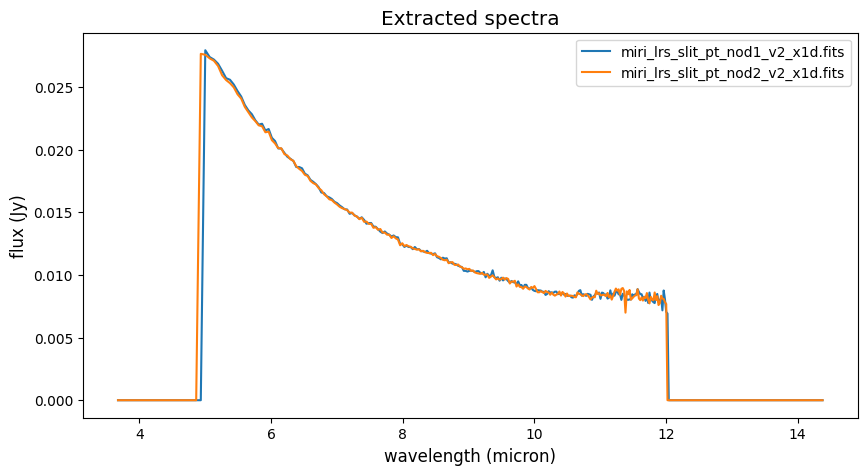

In [9]:
x1ds = glob.glob('*_x1d.fits')

fig = plt.figure(figsize=[10,5])

for xx in x1ds:
    sp = datamodels.open(xx)
    lab = sp.meta.filename
    plt.plot(sp.spec[0].spec_table['WAVELENGTH'], sp.spec[0].spec_table['FLUX'], label=lab)

plt.title('Extracted spectra', fontsize='x-large')
plt.xlabel('wavelength (micron)', fontsize='large')
plt.legend()
plt.ylabel('flux (Jy)', fontsize='large')
fig.show()



### Spec3 Pipeline

Next we run the Spec3 Pipeline. This also takes an association file as input, which lists the associated science files that will need to be combined into a single product.

[Top of Page](#title_ID)


In [10]:
# use asn_from_list to create association table

calfiles = glob.glob('*_cal.fits')
asn = asn_from_list(calfiles, rule=DMS_Level3_Base, product_name='lrs_slit_pipetest_combined.fits')

# dump association table to a .json file for use in image3
with open('lrs_slit_pipetest_stage3.json', 'w') as fp:
    fp.write(asn.dump()[1])

print(asn)    

jwnoprogram-a3001_none_00003_asn with 1 products
Rule=DMS_Level3_Base
No constraints
Products:
	lrs_slit_pipetest_combined.fits with 2 members


In [11]:
sp3 = Spec3Pipeline.call('lrs_slit_pipetest_stage3.json', save_results=True)


2022-12-04 04:55:43,321 - stpipe - INFO - PARS-SPEC3PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-spec3pipeline_0001.asdf


2022-12-04 04:55:43,340 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.


2022-12-04 04:55:43,342 - stpipe.Spec3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.


2022-12-04 04:55:43,343 - stpipe.Spec3Pipeline.master_background - INFO - MasterBackgroundStep instance created.


2022-12-04 04:55:43,344 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.


2022-12-04 04:55:43,345 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2022-12-04 04:55:43,347 - stpipe.Spec3Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2022-12-04 04:55:43,349 - stpipe.Spec3Pipeline.cube_build - INFO - CubeBuildStep instance created.


2022-12-04 04:55:43,350 - stpipe.Spec3Pipeline.extract_1d - INFO - Extract1dStep instance created.


2022-12-04 04:55:43,351 - stpipe.Spec3Pipeline.photom - INFO - PhotomStep instance created.


2022-12-04 04:55:43,352 - stpipe.Spec3Pipeline.combine_1d - INFO - Combine1dStep instance created.


2022-12-04 04:55:43,500 - stpipe.Spec3Pipeline - INFO - Step Spec3Pipeline running with args ('lrs_slit_pipetest_stage3.json',).


2022-12-04 04:55:43,507 - stpipe.Spec3Pipeline - INFO - Step Spec3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'steps': {'assign_mtwcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_mtwcs', 'search_output_file': True, 'input_dir': ''}, 'master_background': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'user_background': None, 'save_background': False, 'force_subtract': False}, 'mrs_imatch': {'pre_ho

2022-12-04 04:55:43,665 - stpipe.Spec3Pipeline - INFO - Prefetching reference files for dataset: 'miri_lrs_slit_pt_nod1_v2_cal.fits' reftypes = ['apcorr', 'area', 'cubepar', 'drizpars', 'extract1d', 'photom', 'speckernel', 'specprofile', 'spectrace', 'wavemap']


2022-12-04 04:55:43,668 - stpipe.Spec3Pipeline - INFO - Prefetch for APCORR reference file is '/grp/crds/cache/references/jwst/jwst_miri_apcorr_0007.fits'.


2022-12-04 04:55:43,669 - stpipe.Spec3Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2022-12-04 04:55:43,670 - stpipe.Spec3Pipeline - INFO - Prefetch for CUBEPAR reference file is 'N/A'.


2022-12-04 04:55:43,670 - stpipe.Spec3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-12-04 04:55:43,671 - stpipe.Spec3Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/grp/crds/cache/references/jwst/jwst_miri_extract1d_0004.json'.


2022-12-04 04:55:43,672 - stpipe.Spec3Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0072.fits'.


2022-12-04 04:55:43,673 - stpipe.Spec3Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2022-12-04 04:55:43,674 - stpipe.Spec3Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2022-12-04 04:55:43,674 - stpipe.Spec3Pipeline - INFO - Prefetch for SPECTRACE reference file is 'N/A'.


2022-12-04 04:55:43,675 - stpipe.Spec3Pipeline - INFO - Prefetch for WAVEMAP reference file is 'N/A'.


2022-12-04 04:55:43,676 - stpipe.Spec3Pipeline - INFO - Starting calwebb_spec3 ...


2022-12-04 04:55:44,116 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<ModelContainer>,).


2022-12-04 04:55:44,118 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'crf', 'search_output_file': False, 'input_dir': '', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None, 'in_memory': False}


2022-12-04 04:55:44,125 - stpipe.Spec3Pipeline.outlier_detection - INFO - Performing outlier detection on 2 inputs


2022-12-04 04:55:44,293 - stpipe.Spec3Pipeline.outlier_detection - INFO - Driz parameter kernal: square


2022-12-04 04:55:44,294 - stpipe.Spec3Pipeline.outlier_detection - INFO - Driz parameter pixfrac: 1.0


2022-12-04 04:55:44,295 - stpipe.Spec3Pipeline.outlier_detection - INFO - Driz parameter fillval: INDEF


2022-12-04 04:55:44,295 - stpipe.Spec3Pipeline.outlier_detection - INFO - Driz parameter weight_type: ivm


2022-12-04 04:55:44,316 - stpipe.Spec3Pipeline.outlier_detection - INFO - 1 exposures to drizzle together


2022-12-04 04:55:45,078 - stpipe.Spec3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (387, 62)


2022-12-04 04:55:45,200 - stpipe.Spec3Pipeline.outlier_detection - INFO - Exposure miri_lrs_slit_pt_nod1_v2_outlier_i2d.fits saved to file


2022-12-04 04:55:45,207 - stpipe.Spec3Pipeline.outlier_detection - INFO - 1 exposures to drizzle together


2022-12-04 04:55:46,013 - stpipe.Spec3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (387, 62)


2022-12-04 04:55:46,126 - stpipe.Spec3Pipeline.outlier_detection - INFO - Exposure miri_lrs_slit_pt_nod2_v2_outlier_i2d.fits saved to file


2022-12-04 04:55:46,655 - stpipe.Spec3Pipeline.outlier_detection - INFO - Blotting median...


2022-12-04 04:55:47,528 - stpipe.Spec3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (387, 62)


2022-12-04 04:55:48,622 - stpipe.Spec3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (387, 62)


2022-12-04 04:55:48,835 - stpipe.Spec3Pipeline.outlier_detection - INFO - Flagging outliers


2022-12-04 04:55:49,064 - stpipe.Spec3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 0 (0.00%)


2022-12-04 04:55:49,470 - stpipe.Spec3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 0 (0.00%)


2022-12-04 04:55:49,796 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in miri_lrs_slit_pt_nod1_v2_a3001_crf.fits


2022-12-04 04:55:50,116 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in miri_lrs_slit_pt_nod2_v2_a3001_crf.fits


2022-12-04 04:55:50,117 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done


2022-12-04 04:55:50,270 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<ModelContainer>,).


2022-12-04 04:55:50,272 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None, 'in_memory': True}


2022-12-04 04:55:50,289 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2022-12-04 04:55:50,485 - stpipe.Spec3Pipeline.resample_spec - INFO - Driz parameter kernal: square


2022-12-04 04:55:50,486 - stpipe.Spec3Pipeline.resample_spec - INFO - Driz parameter pixfrac: 1.0


2022-12-04 04:55:50,487 - stpipe.Spec3Pipeline.resample_spec - INFO - Driz parameter fillval: INDEF


2022-12-04 04:55:50,488 - stpipe.Spec3Pipeline.resample_spec - INFO - Driz parameter weight_type: ivm


2022-12-04 04:55:50,537 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for lrs_slit_pipetest_combined.fits


2022-12-04 04:55:51,208 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data


2022-12-04 04:55:51,973 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 62)


2022-12-04 04:55:52,780 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 62)


2022-12-04 04:55:52,796 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_rnoise


2022-12-04 04:55:53,586 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 62)


2022-12-04 04:55:54,381 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 62)


2022-12-04 04:55:54,389 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson


2022-12-04 04:55:55,202 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 62)


2022-12-04 04:55:55,975 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 62)


2022-12-04 04:55:55,983 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat


2022-12-04 04:55:56,841 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 62)


2022-12-04 04:55:57,658 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 62)


2022-12-04 04:55:57,685 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  0.000023281 -0.000055433 359.999992655 -0.000055433 359.999992655 0.000099853 0.000023281 0.000099853


2022-12-04 04:55:58,130 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in lrs_slit_pipetest_combined_s2d.fits


2022-12-04 04:55:58,131 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done


2022-12-04 04:55:58,318 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(387, 62) from lrs_slit_pipetest_combined_s2d.fits>,).


2022-12-04 04:55:58,320 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}


2022-12-04 04:55:58,423 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0004.json


2022-12-04 04:55:58,475 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0007.fits


2022-12-04 04:55:58,517 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_LRS-FIXEDSLIT


2022-12-04 04:55:58,517 - stpipe.Spec3Pipeline.extract_1d - WARNING - spectral_order is None; using 1


2022-12-04 04:55:58,518 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order 1


2022-12-04 04:55:58,530 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of 0.26 to xstart and xstop


2022-12-04 04:55:58,531 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: xstart=25.760167236882968, xstop=35.760167236882964, ystart=0, ystop=386


2022-12-04 04:55:58,628 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.


2022-12-04 04:55:58,954 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in lrs_slit_pipetest_combined_x1d.fits


2022-12-04 04:55:58,955 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done


2022-12-04 04:55:58,956 - stpipe.Spec3Pipeline - INFO - Ending calwebb_spec3


2022-12-04 04:55:58,956 - stpipe.Spec3Pipeline - INFO - Step Spec3Pipeline done


## Plots & tests

We produce some plots below to check the output of the resample step. What are we looking for?

* The combined 2D image should be 387 (rows) x 62 (columns) in size. 
* The combined resampled image (the positive trace) should be centred in the image, flanked by 2 negative traces which correspond to the subtarcted complementary traces from the individual nod images. We check in the plot below that the trace is centred.

* In the extracted products, the wavelength calibration for all 3 spectra should match - there should be no systematic offset. 

There aren't numerical tests for all these checks so they do require some visual inspection. 

In [12]:
s2d3_file = glob.glob('*pipetest*_s2d.fits')
s2d3 = datamodels.open(s2d3_file[0])
x1d3_file = glob.glob('*pipetest*_x1d.fits')
x1d3 = datamodels.open(x1d3_file[0])

assert np.shape(s2d3.data)==(387,62), "Spec3 output does not have the expected shape. Its shape is {0}".format(np.shape(s2d3.data)
                                                                                                              )

['miri_lrs_slit_pt_nod1_v2_s2d.fits', 'miri_lrs_slit_pt_nod2_v2_s2d.fits']


Text(0.5, 1.0, 'Combined resampled image (Spec3)')

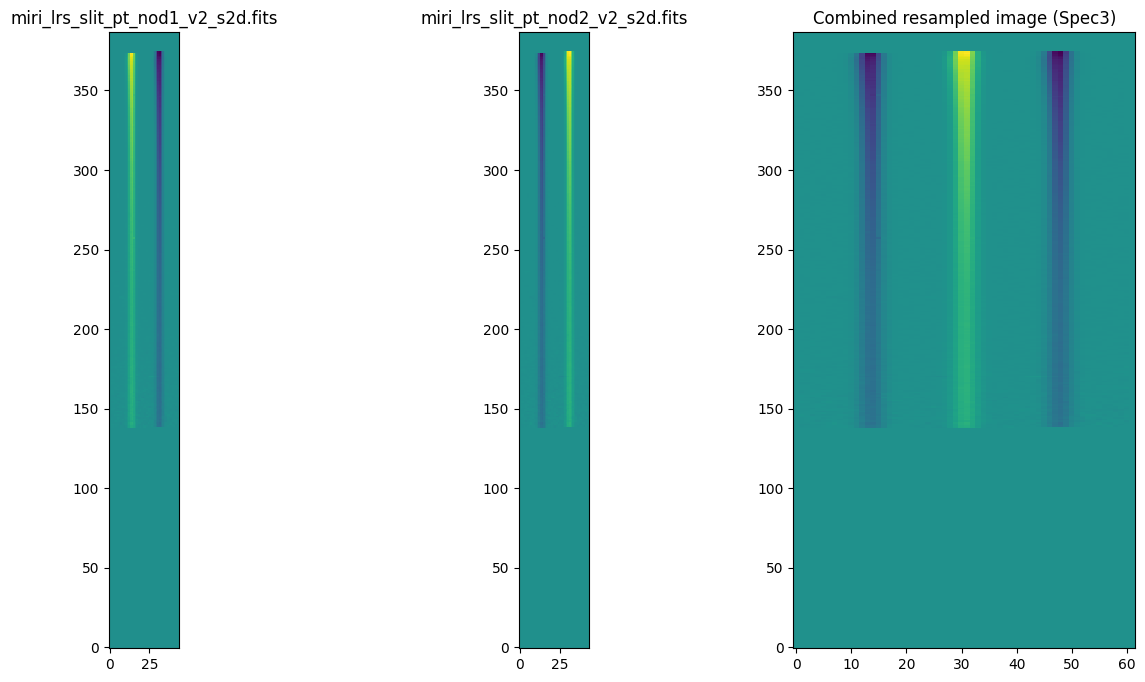

In [13]:


# the spec2 resampled files
s2d2_file = glob.glob('*nod*_s2d.fits')
print(s2d2_file)

fig1, ax = plt.subplots(ncols=3, nrows=1, figsize=[15,8])
for ii, ff in enumerate(s2d2_file):
    s2d2 = datamodels.open(ff)
    ax[ii].imshow(s2d2.data, origin='lower', interpolation='None')
    ax[ii].set_title(s2d2.meta.filename)
    


ax[2].imshow(s2d3.data, origin='lower', aspect='auto', interpolation='None')
ax[2].set_title('Combined resampled image (Spec3)')


    


Text(0.5, 1.0, 'Comparison of extracted spectra (spec 2 and spec 3)')

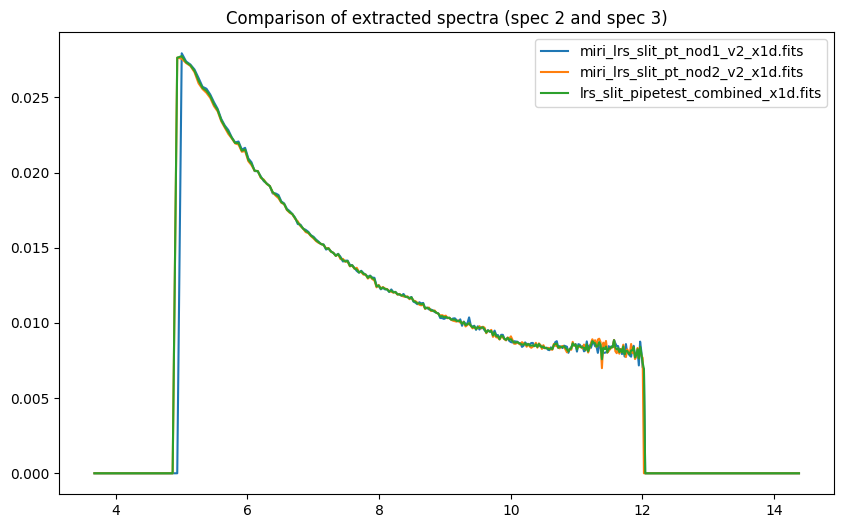

In [14]:
extracted_files = glob.glob('*_x1d.fits')

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=[10,6])

for ef in extracted_files:
    x1d = datamodels.open(ef)
    ax.plot(x1d.spec[0].spec_table['WAVELENGTH'], x1d.spec[0].spec_table['FLUX'], label=x1d.meta.filename)

ax.legend()
ax.set_title('Comparison of extracted spectra (spec 2 and spec 3)')

<a id="about_ID"></a>
## About this Notebook
**Author:** S. Kendrew, sarah.kendrew@esa.int, ESA and INS/STScI
<br>**Updated On:** May 28th 2021 (first version)

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 